# Assigment 2

- 課題1で使用した文書のトピックについて分析を行う / Analyze the topics of documents used in Assignment 1.
- トピックモデルLDA(Latent Dirichlet Allocation)を利用 / Use Topic Model LDA(Latent Dirichlet Allocation)

# Import

__必要なモジュールをインポート__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import collections
import glob

__nltkの機能を追加__

In [2]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("reuters")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/takuto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/takuto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to /Users/takuto/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /Users/takuto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
#dataset読み込み
from nltk.corpus import reuters as corpus

__データ取得__

一部のデータは以下のサイトから取得:

https://www.kaggle.com/datasets/jensenbaxter/10dataset-text-document-classification?resource=download

Business, Entertainment, Food, Politics, Sport, Technologieから50個ずつ文書を取得

加えて、オリジナルのテキスト一つ(music)を追加

In [4]:
documents = []

# Dataディレクトリ内全ての文書を獲得
path_data = "./Data2/"
files = glob.glob(f"{path_data}*.txt")
print(len(files))

for file in files:
    with open(file, 'r') as f:
        documents.append([file, f.read()])

1001


In [5]:
print(len(documents), "文書")

1001 文書


# Preprocessing

## 正規表現を用いて整形

In [6]:
import re

def cleaning_text(text):
    # \nの削除
    pattern1 = '\n'
    text = re.sub(pattern1, '', text)    
    # \nタグの削除　
    pattern2 = '\(.*\)' 
    text = re.sub(pattern2, '', text)
    return text
  

# for path, text in documents:
#     print(cleaning_text(text))

## 空白区切りにする+記号の削除

In [7]:
def tokenize_text(text):
    text = re.sub('[!#$%&()*,\-\/:;\<\>?@\"\[\\\]\^\_`\{\}~]+', ' ', text)
    text = re.sub('-', ' ', text)
    text = re.sub('"', ' ', text)
    text = re.sub('\.', ' ', text)
    text = re.sub('\|', ' ', text)
    text = re.sub('>', ' ', text)
    text = re.sub('<', ' ', text)
    text = re.sub('\/', ' ', text)
    return text.split()

# for path, text in documents:
#     text = cleaning_text(text)
#     print(tokenize_text(text))

## その他の処理

### Stop Words

In [8]:
# nltkのライブラリより + よく使われる単語
en_stop = nltk.corpus.stopwords.words('english') + ["say", "also", "mr", "ms", "year", "would", "us", "one", "people", "make", "show", "take", "use", "add", "go", "new", "come", "could", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve", "get", "first", "may", "best", "since", "well", "e", "many", "much", "last", "great", "like"]
# 正規表現で数字列や百分率表記を抽出
stopwordset_Regular_Expression = ["[0-9]+",'[0-9]*%','\$[0-9]*', "\£[a-z0-9]*"]

In [9]:
print(en_stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## 前処理の関数化

In [10]:
from nltk.corpus import wordnet as wn #lemmatize関数のためのimport
import re

def preprocess_word(word, stopwordset):
    
    #1. 大文字を小文字へ: Python =>python
    word=word.lower()
    
    #2. ","や"."を削除
    if word in [",","."]:
        return None
    
    #3. 上記のstopwordを削除 ex: the => (None) 
    if word in stopwordset:
        return None
    
    #4. 数字や割合が含まれる単語は削除(正規表現で)
    for ex in stopwordset_Regular_Expression:
        if(re.match(ex, word)):
            return None
    
    #5. lemmatize(活用形を統一)  ex: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma
    
# 関数化(単一のDocument)
def preprocess_document(document):
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

# 関数化(複数のDocument)
def preprocess_documents(documents):
    return [preprocess_document(document) for document in documents]

In [11]:
words = []
for path, document in documents:
    document = cleaning_text(document)
    document = tokenize_text(document)
    document = preprocess_document(document)
#     words.append(document)
    words.append([path, document])
#     print([path, document])

In [12]:
def path_delete(filepath):
    filepath = re.sub(path_data, '', filepath)
    return filepath

pre_docs=[doc for [path ,doc] in words]
pre_file=[path for [path ,doc] in words]
for id_num, i_path in enumerate(pre_file):
    pre_file[id_num] = path_delete(i_path)
    
print("The amount of Documentation:", len(pre_docs))

The amount of Documentation: 1001


# LDA準備

In [13]:
import gensim
from gensim import corpora

In [14]:
#documentを，gensim LDAが読み込めるデータ構造にする

#辞書の作成
dictionary = corpora.Dictionary(pre_docs)
#コーパスの作成
corpus_ = [dictionary.doc2bow(doc) for doc in pre_docs]

In [15]:
#Dictionary:gensimにおける辞書クラス
#token2id属性には単語と辞書IDとの対応が格納される

print(dictionary.token2id)

{'almost': 0, 'although': 1, 'andgeb@cadre': 2, 'anything': 3, 'article': 4, 'banks': 5, 'base': 6, 'cancer': 7, 'certitude': 8, 'chastity': 9, 'chemotherapy': 10, 'common': 11, 'difficultto': 12, 'dsl': 13, 'edu': 14, 'everything': 15, 'found': 16, 'goodexplanation': 17, 'gordon': 18, 'haveradiation': 19, 'hormone': 20, 'intellect,': 21, 'isprobably': 22, 'mostmedical': 23, 'n3jxp': 24, 'pitt': 25, 'pjs269@tijc02': 26, 'prostate': 27, 'prove': 28, 'proven?': 29, 'read': 30, 'sayare': 31, 'science,': 32, 'scientificrationale': 33, 'shameful': 34, 'skepticism': 35, 'somethings': 36, 'soon': 37, 'surrender': 38, 'therapy': 39, 'think': 40, 'this?': 41, 'treatment': 42, 'true': 43, 'uucp': 44, 'work': 45, "'will": 46, 'abbas': 47, 'accept': 48, 'added:': 49, 'ahead': 50, 'all,': 51, 'allege': 52, 'allow': 53, 'ambassador': 54, 'and,': 55, 'annan,': 56, 'arab': 57, 'attack': 58, 'attack,': 59, 'attackspalestinian': 60, 'attend': 61, 'attend,': 62, 'attendance,': 63, 'authority': 64, 'aviv'

In [16]:
#corpusにはdocumentごとに単語の(ID、出現回数)のリストが得られる

print(corpus_[0]) #文章での出現順でなく辞書IDの若い順なことに注意

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 3), (43, 2), (44, 2), (45, 2)]


# LDA学習

In [17]:
num_topics = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus_,
                                           num_topics=num_topics,
                                           id2word=dictionary,
                                           alpha=0.1,                             #optional LDAのハイパーパラメータalpha
                                           eta=0.1,                                 #optional LDAのハイパーパラメータbeta
                                           minimum_probability=0.01   #optional 学習結果に格納するトピック・単語の生起確率の下限
                                          )

## パラメータ学習

In [18]:
#(トピックID, 当該トピックにおける単語とそのprobability)  ※　のうち、上位num_words位 

topics = ldamodel.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.003*"war" + 0.003*"years" + 0.002*"german" + 0.002*"tax" + 0.002*"world" + 0.002*"time" + 0.002*"party" + 0.002*"government" + 0.002*"know" + 0.002*"tell" + 0.002*"company" + 0.002*"british" + 0.002*"plan" + 0.002*"french" + 0.002*"film"')
(1, '0.004*"film" + 0.004*"design" + 0.002*"high" + 0.002*"party" + 0.002*"time" + 0.002*"month" + 0.002*"mobile" + 0.002*"want" + 0.002*"help" + 0.002*"see" + 0.002*"set" + 0.002*"cut" + 0.002*"work" + 0.002*"tell" + 0.002*"british"')
(2, '0.003*"world" + 0.002*"war" + 0.002*"time" + 0.002*"see" + 0.002*"phone" + 0.002*"user" + 0.002*"years" + 0.002*"european" + 0.002*"german" + 0.002*"mobile" + 0.002*"plan" + 0.002*"second" + 0.002*"need" + 0.002*"help" + 0.002*"country"')
(3, '0.003*"war" + 0.003*"government" + 0.002*"world" + 0.002*"uk" + 0.002*"include" + 0.002*"british" + 0.002*"want" + 0.002*"country" + 0.002*"need" + 0.002*"years" + 0.002*"still" + 0.002*"see" + 0.002*"home" + 0.002*"know" + 0.002*"call"')
(4, '0.003*"world" + 0.002*"e

In [19]:
#[(当該documentにおけるトピックIDとそのprobability　)]　 ※　のうち、minimum_probabilityの値を超えるもの

for n,item in enumerate(corpus_[:10]):
    print("document ID "+str(n)+":" ,end="")
    print(ldamodel.get_document_topics(item))

document ID 0:[(7, 0.9836047)]
document ID 1:[(5, 0.18602522), (9, 0.80960345)]
document ID 2:[(1, 0.5332762), (6, 0.45961854)]
document ID 3:[(3, 0.14300093), (8, 0.8537796)]
document ID 4:[(3, 0.99487364)]
document ID 5:[(4, 0.98952585)]
document ID 6:[(1, 0.99522364)]
document ID 7:[(2, 0.9915785)]
document ID 8:[(5, 0.94698757)]
document ID 9:[(4, 0.9689179)]


In [20]:
for n in range(10):
    print(n+1, "番目")
    #n番目のdocumentのトピック分布
    print(ldamodel.get_document_topics(corpus_[n]))

    #n番目のdocumentのcategory
    print(pre_file[n])

    #n番目のdocumentの生の文章
#     print(" ".join(pre_docs[n]))

1 番目
[(7, 0.9836047)]
medical_67.txt
2 番目
[(5, 0.18766963), (9, 0.80795914)]
politics_209.txt
3 番目
[(1, 0.53495), (6, 0.45794472)]
entertainment_39.txt
4 番目
[(3, 0.1407985), (8, 0.85598207)]
politics_221.txt
5 番目
[(3, 0.99487376)]
entertainment_11.txt
6 番目
[(4, 0.98952585)]
politics_235.txt
7 番目
[(1, 0.99522364)]
entertainment_1.txt
8 番目
[(2, 0.9915785)]
sport_1.txt
9 番目
[(5, 0.9469875)]
medical_319.txt
10 番目
[(4, 0.9689178)]
space_32.txt


(7, 0.98360467)


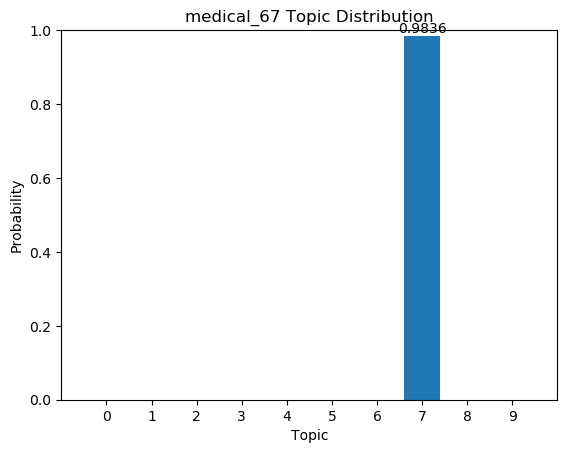

(5, 0.18868163) (9, 0.8069471)


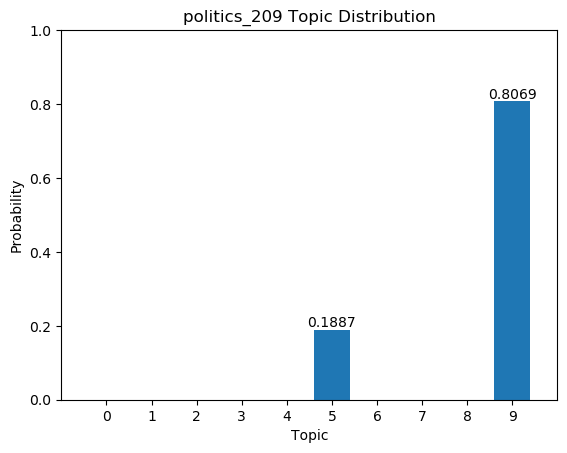

(1, 0.53094673) (6, 0.46194798)


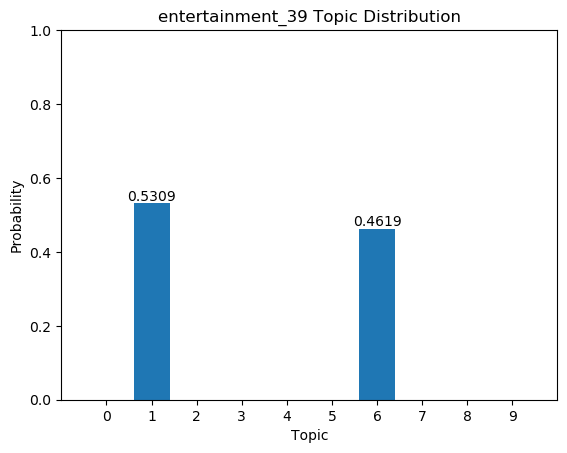

(3, 0.1389008) (8, 0.8578798)


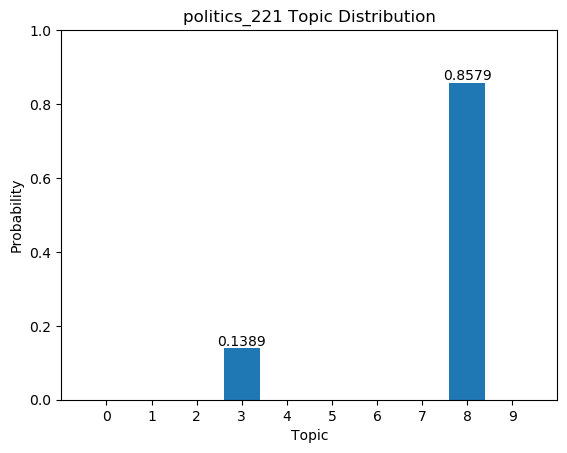

(3, 0.99487376)


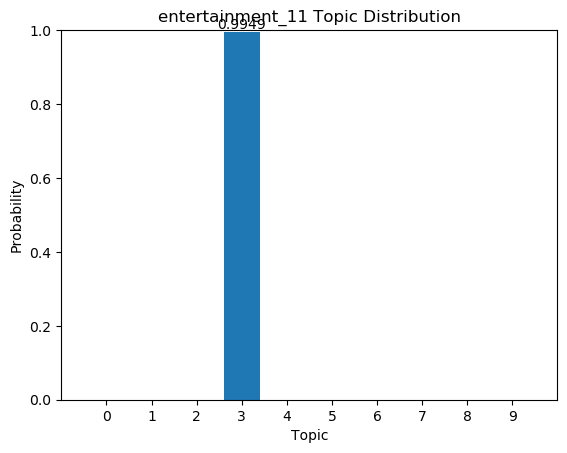

(4, 0.98952585)


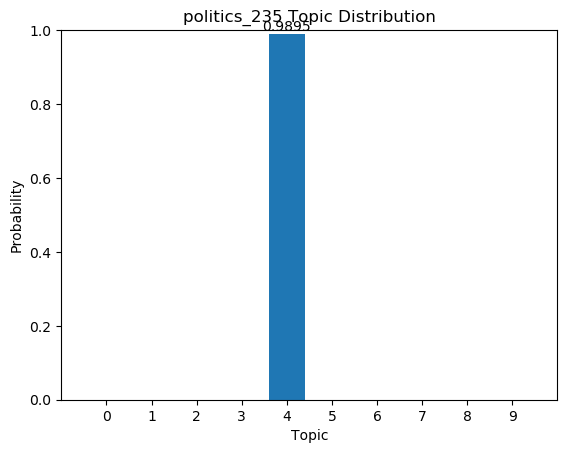

(1, 0.9952236)


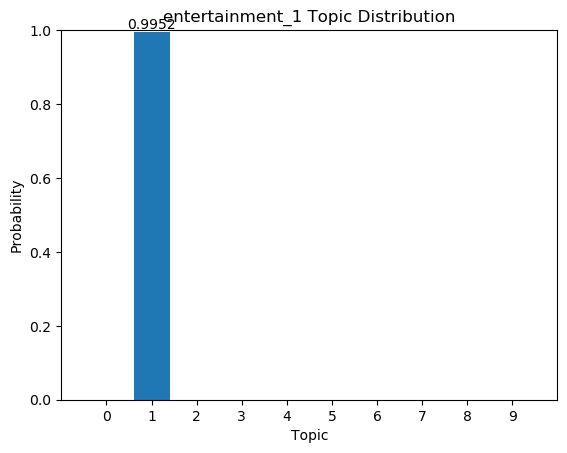

(2, 0.99157846)


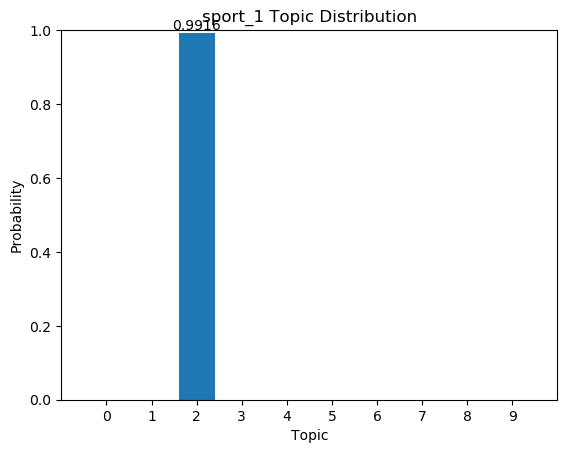

(5, 0.9469874)


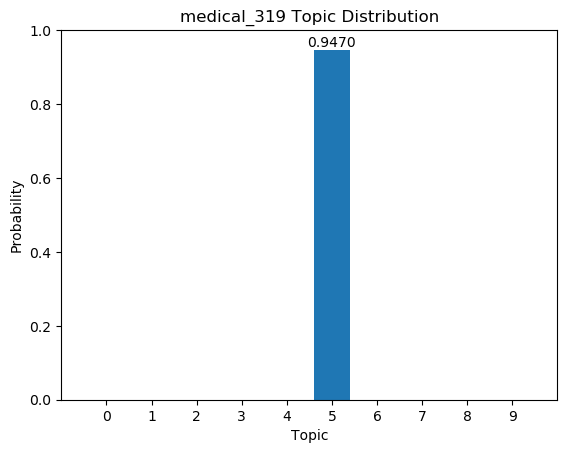

(4, 0.96891767)


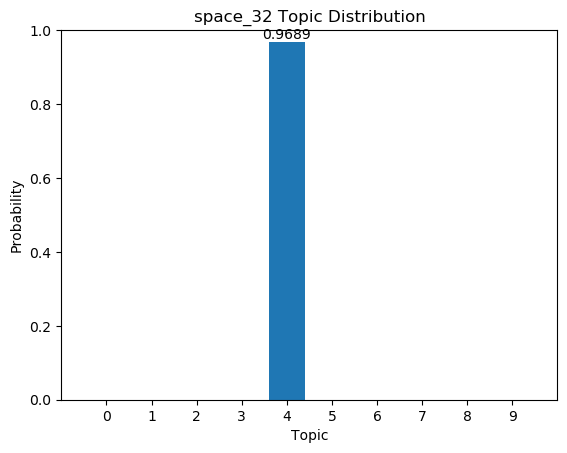

In [21]:
# 文書毎のトピック分類をグラフ化

# 各文書のトピック分布を格納するリストを作成
topic_distributions = []

# 各文書のトピック分布を取得してリストに追加
for n in range(num_topics):
    topic_distributions.append(ldamodel.get_document_topics(corpus_[n]))
    
# グラフ化
for i, (topic_dist, file_name) in enumerate(zip(topic_distributions, pre_file)):
    file_name_notxt = re.sub('.txt', '', file_name)
    
    plt.figure()
    topics, probabilities = zip(*topic_dist)
    print(*topic_dist)
    plt.bar(topics, probabilities)
    plt.xlim(-1, num_topics)
    plt.ylim(0, 1)
    plt.xlabel("Topic")
    plt.ylabel("Probability")
    plt.title(f"{file_name_notxt} Topic Distribution")
    
    for i in range(len(topics)):
        plt.text(topics[i], probabilities[i], f"{probabilities[i]:.4f}", ha="center", va="bottom")
        
    plt.xticks(range(num_topics))
    
    plt.savefig(f"./img/{file_name_notxt}.png")
    plt.show()

# 可視化

In [22]:
# import pyLDAvis.gensim
from imp import reload
import pyLDAvis.gensim_models
from imp import reload
pyLDAvis.enable_notebook()

/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  
/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [23]:
# リスト化
df =pd.DataFrame()
for t in range(10):
    word=[]
    for i, prob in ldamodel.get_topic_terms(t, topn=10):
        word.append(dictionary.id2token[int(i)])
    _ = pd.DataFrame([word],index=[f'topic{t+1}'])
    df = df.append(_)
df.T

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,war,film,world,war,world,world,film,month,time,war
1,years,design,war,government,election,film,cup,tell,edu,german
2,german,high,time,world,know,edu,time,want,german,world
3,tax,party,see,uk,party,include,british,world,help,government
4,world,time,phone,include,include,music,world,information,know,lord
5,time,month,user,british,report,com,record,next,world,british
6,party,mobile,years,want,part,award,design,war,include,time
7,government,want,european,country,school,help,next,help,company,battle
8,know,help,german,need,time,set,german,european,war,cup
9,tell,see,mobile,years,need,see,help,time,see,minister


In [24]:
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus_, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## 比較実験

In [25]:
# 5種類に分類
num_topics=5
ldamodel2 = gensim.models.ldamodel.LdaModel(corpus=corpus_,
                                           num_topics=num_topics,
                                           id2word=dictionary,
                                           alpha=0.1,                             #optional LDAのハイパーパラメータalpha
                                           eta=0.1,                                 #optional LDAのハイパーパラメータbeta
                                           #minimum_probability=0.0    #optional 学習結果に格納するトピック・単語の生起確率の下限
                                          )

for n in range(10):
    print(n+1, "番目")
    #n番目のdocumentのトピック分布
    print(ldamodel.get_document_topics(corpus_[n]))

    #n番目のdocumentのcategory
    print(pre_file[n])

lda_display2 = pyLDAvis.gensim_models.prepare(ldamodel2, corpus_, dictionary, sort_topics=False)
pyLDAvis.display(lda_display2)

1 番目
[(7, 0.9836047)]
medical_67.txt
2 番目
[(5, 0.18937472), (9, 0.806254)]
politics_209.txt
3 番目
[(1, 0.5342731), (6, 0.45862165)]
entertainment_39.txt
4 番目
[(3, 0.14298595), (8, 0.8537946)]
politics_221.txt
5 番目
[(3, 0.99487376)]
entertainment_11.txt
6 番目
[(4, 0.98952585)]
politics_235.txt
7 番目
[(1, 0.99522364)]
entertainment_1.txt
8 番目
[(2, 0.9915785)]
sport_1.txt
9 番目
[(5, 0.9469874)]
medical_319.txt
10 番目
[(4, 0.9689179)]
space_32.txt


In [26]:
# リスト化
df =pd.DataFrame()
for t in range(num_topics):
    word=[]
    for i, prob in ldamodel2.get_topic_terms(t, topn=10):
        word.append(dictionary.id2token[int(i)])
    _ = pd.DataFrame([word],index=[f'topic{t+1}'])
    df = df.append(_)
df.T

,topic1,topic2,topic3,topic4,topic5
0,film,world,world,tell,german
1,world,war,time,see,world
2,help,time,war,food,war
3,government,government,design,want,british
4,edu,years,cup,expect,european
5,need,lord,see,party,time
6,time,include,include,war,film
7,know,month,help,know,back
8,way,mobile,film,film,next
9,tell,british,teaspoon,time,years


In [27]:
# 20種類に分類
num_topics=20

ldamodel2 = gensim.models.ldamodel.LdaModel(corpus=corpus_,
                                           num_topics=num_topics,
                                           id2word=dictionary,
                                           alpha=0.1,                             #optional LDAのハイパーパラメータalpha
                                           eta=0.1,                                 #optional LDAのハイパーパラメータbeta
                                           #minimum_probability=0.0    #optional 学習結果に格納するトピック・単語の生起確率の下限
                                          )

for n in range(10):
    print(n+1, "番目")
    #n番目のdocumentのトピック分布
    print(ldamodel.get_document_topics(corpus_[n]))

    #n番目のdocumentのcategory
    print(pre_file[n])

    

lda_display2 = pyLDAvis.gensim_models.prepare(ldamodel2, corpus_, dictionary, sort_topics=False)
pyLDAvis.display(lda_display2)

1 番目
[(7, 0.98360455)]
medical_67.txt
2 番目
[(5, 0.1879288), (9, 0.8076999)]
politics_209.txt
3 番目
[(1, 0.53468907), (6, 0.45820564)]
entertainment_39.txt
4 番目
[(3, 0.13944966), (8, 0.8573309)]
politics_221.txt
5 番目
[(3, 0.99487376)]
entertainment_11.txt
6 番目
[(4, 0.98952585)]
politics_235.txt
7 番目
[(1, 0.9952236)]
entertainment_1.txt
8 番目
[(2, 0.9915785)]
sport_1.txt
9 番目
[(5, 0.94698757)]
medical_319.txt
10 番目
[(4, 0.9689179)]
space_32.txt


In [28]:
# リスト化
df =pd.DataFrame()
for t in range(num_topics):
    word=[]
    for i, prob in ldamodel2.get_topic_terms(t, topn=10):
        word.append(dictionary.id2token[int(i)])
    _ = pd.DataFrame([word],index=[f'topic{t+1}'])
    df = df.append(_)
df.T

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,topic20
0,war,film,film,world,design,help,design,world,election,world,tell,war,war,food,government,film,film,war,world,german
1,million,design,month,german,time,german,music,user,include,war,game,time,party,software,time,world,tell,time,government,war
2,teaspoon,sales,british,war,war,world,mobile,time,see,years,help,british,police,war,number,british,month,right,war,british
3,found,world,music,time,back,government,graphic,image,still,phone,test,lord,end,set,home,include,government,german,time,edu
4,world,know,award,british,lord,time,pepper,war,world,cup,time,work,world,world,world,award,know,british,game,world
5,see,years,know,call,award,high,cup,cup,la,know,point,month,edu,program,years,party,need,know,de,space
6,time,graphic,want,american,party,council,world,design,want,time,include,years,election,include,expect,see,job,mobile,race,battle
7,cup,time,part,know,help,food,green,company,uk,mobile,world,report,american,time,war,tell,call,see,design,film
8,phone,european,director,include,tell,war,tablespoon,know,tv,need,need,uk,see,design,party,life,help,world,next,force
9,home,see,see,company,chancellor,tax,teaspoon,call,part,german,end,place,know,become,back,time,market,uk,country,need


/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _nlv = LooseVersion(_np_version)
/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p16 = _nlv < LooseVersion("1.16")
/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p17 = _nlv < LooseVersion("1.17")
/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p18 = _nlv < LooseVersion("1.18")
/Users/takuto/opt/anaconda3

/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _nlv = LooseVersion(_np_version)
/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p16 = _nlv < LooseVersion("1.16")
/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p17 = _nlv < LooseVersion("1.17")
/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p18 = _nlv < LooseVersion("1.18")
/Users/takuto/opt/anaconda3

/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _nlv = LooseVersion(_np_version)
/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p16 = _nlv < LooseVersion("1.16")
/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p17 = _nlv < LooseVersion("1.17")
/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p18 = _nlv < LooseVersion("1.18")
/Users/takuto/opt/anaconda3

/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _nlv = LooseVersion(_np_version)
/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p16 = _nlv < LooseVersion("1.16")
/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p17 = _nlv < LooseVersion("1.17")
/Users/takuto/opt/anaconda3/envs/ISA/lib/python3.7/site-packages/pandas/compat/numpy/__init__.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p18 = _nlv < LooseVersion("1.18")
/Users/takuto/opt/anaconda3